In [6]:
print("\n" + "=" * 70)
print("STEP 1 (REVISED): DATA PREPARATION")
print("=" * 70)

# Load the data
data_path = Path(r'D:\code\SEG\data\silver\zillow\home_values\wide.parquet')
df = pd.read_parquet(data_path)

print(f"\n📊 Raw data loaded: {df.shape}")

# Step 1.1: Filter to state-level, all homes, ALL bedrooms
state_data = df[
    (df['Region Type'] == 4) &      # State level
    (df['Home Type'] == 3) &         # All homes
    (df['Bedroom Count'] == 5)       # 5 = All Bedrooms (aggregate)
].copy()

print(f"\n✓ Filtered to states, all homes, all bedrooms: {state_data.shape}")
print(f"  Unique states: {state_data['State'].nunique()}")

# Step 1.2: Convert timestamp and select columns
state_data['date'] = pd.to_datetime(state_data['Date'], unit='ms')
state_data = state_data[['State', 'date', 'Mid Tier ZHVI (Smoothed) (Seasonally Adjusted)']].copy()
state_data.columns = ['State', 'Date', 'ZHVI']

# Step 1.3: Include 2017 data for YoY calculation
state_data = state_data[state_data['Date'] >= '2017-01-01'].copy()
state_data = state_data.sort_values(['State', 'Date']).reset_index(drop=True)

print(f"\n✓ Loaded data from 2017+ (for YoY calculation): {state_data.shape}")
print(f"  Date range: {state_data['Date'].min()} to {state_data['Date'].max()}")

# Step 1.4: Calculate YoY percentage change
state_data['ZHVI_12mo_ago'] = state_data.groupby('State')['ZHVI'].shift(12)
state_data['Price_YoY'] = (state_data['ZHVI'] / state_data['ZHVI_12mo_ago']) - 1

# Step 1.5: Filter to 2018+ for analysis (now with complete YoY data)
analysis_data = state_data[
    (state_data['Date'] >= '2018-01-01') & 
    (state_data['Price_YoY'].notna())
][['State', 'Date', 'Price_YoY']].copy()

print(f"\n✓ Calculated YoY price growth")
print(f"  Analysis dataset: {analysis_data.shape}")
print(f"  Analysis period: {analysis_data['Date'].min()} to {analysis_data['Date'].max()}")
print(f"  States included: {analysis_data['State'].nunique()}")

# Show sample
print(f"\n📋 Sample Data:")
print(analysis_data.head(10))

# Summary stats
print(f"\n📊 YoY Price Growth Summary:")
print(analysis_data['Price_YoY'].describe().apply(lambda x: f"{x*100:.2f}%"))

print("\n" + "=" * 70)
print("✅ STEP 1 COMPLETE - Data ready for correlation analysis")
print("=" * 70)


STEP 1 (REVISED): DATA PREPARATION

📊 Raw data loaded: (117912, 18)

✓ Filtered to states, all homes, all bedrooms: (14739, 18)
  Unique states: 51

✓ Loaded data from 2017+ (for YoY calculation): (4335, 3)
  Date range: 2017-01-31 00:00:00 to 2024-01-31 00:00:00

✓ Calculated YoY price growth
  Analysis dataset: (3721, 3)
  Analysis period: 2018-01-31 00:00:00 to 2024-01-31 00:00:00
  States included: 51

📋 Sample Data:
      State       Date  Price_YoY
12  Alabama 2018-01-31   0.032945
13  Alabama 2018-02-28   0.033702
14  Alabama 2018-03-31   0.037216
15  Alabama 2018-04-30   0.039684
16  Alabama 2018-05-31   0.042152
17  Alabama 2018-06-30   0.042569
18  Alabama 2018-07-31   0.043602
19  Alabama 2018-08-31   0.043855
20  Alabama 2018-09-30   0.043657
21  Alabama 2018-10-31   0.041036

📊 YoY Price Growth Summary:
count    372100.00%
mean          7.70%
std           5.96%
min          -9.88%
25%           3.95%
50%           6.32%
75%          10.80%
max          40.36%
Name: Price

In [7]:
print("\n" + "=" * 70)
print("STEP 2: BUILD STATE × DATE MATRIX")
print("=" * 70)

# Step 2.1: Pivot to wide format (each column = a state)
price_matrix = analysis_data.pivot(
    index='Date',
    columns='State',
    values='Price_YoY'
)

print(f"\n✓ Pivoted to wide format")
print(f"  Dimensions: {price_matrix.shape[0]} dates × {price_matrix.shape[1]} states")
print(f"  Date range: {price_matrix.index.min()} to {price_matrix.index.max()}")

# Step 2.2: Check for missing data
missing_count = price_matrix.isna().sum().sum()
total_cells = price_matrix.shape[0] * price_matrix.shape[1]

print(f"\n📋 Missing Data Check:")
print(f"  Total cells: {total_cells:,}")
print(f"  Missing cells: {missing_count:,} ({missing_count / total_cells * 100:.2f}%)")

if missing_count > 0:
    missing_by_state = price_matrix.isna().sum()
    states_with_missing = missing_by_state[missing_by_state > 0].sort_values(ascending=False)
    print(f"\n  States with missing data:")
    for state, count in states_with_missing.items():
        print(f"    • {state}: {count} months")

# Step 2.3: Fill small gaps if needed
if missing_count > 0:
    price_matrix_filled = price_matrix.ffill(limit=2).bfill(limit=1)
    remaining_missing = price_matrix_filled.isna().sum().sum()
    print(f"\n✓ Filled small gaps (forward/backward fill)")
    print(f"  Remaining missing: {remaining_missing:,}")
else:
    price_matrix_filled = price_matrix.copy()
    print(f"\n✓ No missing data - no filling needed!")

# Step 2.4: Final clean matrix (drop any columns/rows with remaining NaN)
price_matrix_clean = price_matrix_filled.dropna(axis=1)  # Drop states with any NaN
price_matrix_clean = price_matrix_clean.dropna(axis=0)   # Drop dates with any NaN

print(f"\n✅ FINAL CLEAN MATRIX:")
print(f"  Dimensions: {price_matrix_clean.shape[0]} dates × {price_matrix_clean.shape[1]} states")
print(f"  Date range: {price_matrix_clean.index.min()} to {price_matrix_clean.index.max()}")
print(f"  States included: {price_matrix_clean.shape[1]}")

# Step 2.5: Show sample of the matrix
print(f"\n📋 Sample Matrix (first 5 dates, first 6 states):")
sample = (price_matrix_clean.iloc[:5, :6] * 100).round(2)
print(sample)

# Step 2.6: Summary statistics
print(f"\n📊 Summary by State (Top 5 & Bottom 5 average growth):")
state_means = (price_matrix_clean.mean() * 100).sort_values(ascending=False)

print("\n  Highest Average Growth:")
for state, value in state_means.head(5).items():
    print(f"    • {state}: {value:.2f}%")

print("\n  Lowest Average Growth:")
for state, value in state_means.tail(5).items():
    print(f"    • {state}: {value:.2f}%")

print("\n" + "=" * 70)
print("✅ STEP 2 COMPLETE - Matrix ready for correlation analysis")
print("=" * 70)


STEP 2: BUILD STATE × DATE MATRIX

✓ Pivoted to wide format
  Dimensions: 73 dates × 51 states
  Date range: 2018-01-31 00:00:00 to 2024-01-31 00:00:00

📋 Missing Data Check:
  Total cells: 3,723
  Missing cells: 2 (0.05%)

  States with missing data:
    • Alaska: 2 months

✓ Filled small gaps (forward/backward fill)
  Remaining missing: 0

✅ FINAL CLEAN MATRIX:
  Dimensions: 73 dates × 51 states
  Date range: 2018-01-31 00:00:00 to 2024-01-31 00:00:00
  States included: 51

📋 Sample Matrix (first 5 dates, first 6 states):
State       Alabama  Alaska  Arizona  Arkansas  California  Colorado
Date                                                                
2018-01-31     3.29    1.27     7.34      3.78       10.61      8.11
2018-02-28     3.37    1.43     7.36      3.88       10.28      7.97
2018-03-31     3.72    1.81     7.33      4.11        9.73      7.80
2018-04-30     3.97    2.02     7.28      4.21        9.30      7.53
2018-05-31     4.22    2.07     7.37      4.28        9

In [8]:
print("\n" + "=" * 70)
print("STEP 3: COMPUTE CORRELATION MATRIX")
print("=" * 70)

# Step 3.1: Calculate pairwise correlations between all states
correlation_matrix = price_matrix_clean.corr()

print(f"\n✓ Computed correlation matrix")
print(f"  Dimensions: {correlation_matrix.shape[0]} × {correlation_matrix.shape[1]} states")
print(f"  Total pairwise correlations: {(correlation_matrix.shape[0] * (correlation_matrix.shape[0] - 1)) // 2:,}")

# Step 3.2: Summary statistics of correlations
# Extract upper triangle (exclude diagonal of 1.0s)
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)
all_correlations = upper_triangle.stack()

print(f"\n📊 Correlation Summary Statistics:")
print(f"  Mean correlation: {all_correlations.mean():.3f}")
print(f"  Median correlation: {all_correlations.median():.3f}")
print(f"  Std deviation: {all_correlations.std():.3f}")
print(f"  Min correlation: {all_correlations.min():.3f}")
print(f"  Max correlation: {all_correlations.max():.3f}")

# Step 3.3: Interpret national synchronization
mean_corr = all_correlations.mean()
print(f"\n🔍 NATIONAL SYNCHRONIZATION ASSESSMENT:")
if mean_corr > 0.8:
    sync_level = "HIGHLY SYNCHRONIZED"
    interpretation = "National cycle dominates - limited regional diversification benefits"
elif mean_corr > 0.5:
    sync_level = "MODERATELY SYNCHRONIZED"
    interpretation = "Regional clusters visible - some diversification possible"
else:
    sync_level = "FRAGMENTED"
    interpretation = "Local cycles dominate - strong diversification opportunities"

print(f"  Level: {sync_level} (mean r = {mean_corr:.3f})")
print(f"  Interpretation: {interpretation}")

# Step 3.4: Find highest and lowest correlated state pairs
print(f"\n📈 Top 5 Most Correlated State Pairs:")
top_pairs = all_correlations.nlargest(5)
for (state1, state2), corr in top_pairs.items():
    print(f"  • {state1} ↔ {state2}: {corr:.3f}")

print(f"\n📉 Top 5 Least Correlated State Pairs:")
bottom_pairs = all_correlations.nsmallest(5)
for (state1, state2), corr in bottom_pairs.items():
    print(f"  • {state1} ↔ {state2}: {corr:.3f}")

# Step 3.5: Identify potential hedge pairs (low/negative correlation)
hedge_candidates = all_correlations[all_correlations < 0.3]
print(f"\n🛡️  Potential Hedge Pairs (correlation < 0.3):")
if len(hedge_candidates) > 0:
    print(f"  Found {len(hedge_candidates)} pairs with low correlation:")
    for (state1, state2), corr in hedge_candidates.nsmallest(10).items():
        print(f"  • {state1} ↔ {state2}: {corr:+.3f}")
else:
    print(f"  No pairs with correlation < 0.3 found")
    print(f"  Lowest correlation: {all_correlations.min():.3f}")

# Step 3.6: Show sample of correlation matrix
print(f"\n📋 Sample Correlation Matrix (first 6 states):")
sample_states = correlation_matrix.columns[:6]
sample_corr = correlation_matrix.loc[sample_states, sample_states]
print(sample_corr.round(3))

print("\n" + "=" * 70)
print("✅ STEP 3 COMPLETE - Ready for clustering analysis")
print("=" * 70)


STEP 3: COMPUTE CORRELATION MATRIX

✓ Computed correlation matrix
  Dimensions: 51 × 51 states
  Total pairwise correlations: 1,275

📊 Correlation Summary Statistics:
  Mean correlation: 0.834
  Median correlation: 0.873
  Std deviation: 0.143
  Min correlation: 0.046
  Max correlation: 0.994

🔍 NATIONAL SYNCHRONIZATION ASSESSMENT:
  Level: HIGHLY SYNCHRONIZED (mean r = 0.834)
  Interpretation: National cycle dominates - limited regional diversification benefits

📈 Top 5 Most Correlated State Pairs:
  • Georgia ↔ Texas: 0.994
  • North Carolina ↔ South Dakota: 0.993
  • Kansas ↔ Oklahoma: 0.992
  • South Carolina ↔ South Dakota: 0.990
  • Minnesota ↔ Oregon: 0.989

📉 Top 5 Least Correlated State Pairs:
  • District of Columbia ↔ North Dakota: 0.046
  • Connecticut ↔ District of Columbia: 0.084
  • District of Columbia ↔ Wyoming: 0.208
  • Alaska ↔ District of Columbia: 0.219
  • District of Columbia ↔ Florida: 0.221

🛡️  Potential Hedge Pairs (correlation < 0.3):
  Found 11 pairs with

In [13]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform

print("\n" + "=" * 70)
print("STEP 4 (REVISED): HIERARCHICAL CLUSTERING")
print("=" * 70)

# Step 4.1: Prepare distance matrix for hierarchical clustering
distance_matrix = 1 - correlation_matrix
distance_vector = squareform(distance_matrix, checks=False)

print(f"\n✓ Converted correlation matrix to distance vector")

# Step 4.2: Perform hierarchical clustering (Ward linkage)
linkage_matrix = linkage(distance_vector, method='ward')

print(f"\n✓ Performed hierarchical clustering")

# Step 4.3: Test different numbers of clusters (3-6)
print(f"\n📊 Testing 3-6 clusters:")

for n_clusters in [3, 4, 5, 6]:
    labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    sil_score = silhouette_score(distance_matrix, labels, metric='precomputed')
    print(f"  {n_clusters} clusters: Silhouette = {sil_score:.3f}")

# Step 4.4: Choose 4 clusters (good balance)
optimal_k = 4
cluster_labels = fcluster(linkage_matrix, optimal_k, criterion='maxclust') - 1  # 0-indexed

print(f"\n✓ Using {optimal_k} clusters for analysis")

# Create cluster assignment dataframe
cluster_df = pd.DataFrame({
    'State': correlation_matrix.index,
    'Cluster': cluster_labels
}).sort_values('Cluster')

print(f"\n📋 CLUSTER ASSIGNMENTS:")
for cluster_id in range(optimal_k):
    states_in_cluster = cluster_df[cluster_df['Cluster'] == cluster_id]['State'].tolist()
    print(f"\n  Cluster {cluster_id + 1} ({len(states_in_cluster)} states):")
    # Print in multiple lines for readability
    for i in range(0, len(states_in_cluster), 8):
        print(f"    {', '.join(states_in_cluster[i:i+8])}")

# Step 4.5: Analyze cluster characteristics
print(f"\n📊 CLUSTER CHARACTERISTICS:")

for cluster_id in range(optimal_k):
    cluster_states = cluster_df[cluster_df['Cluster'] == cluster_id]['State'].tolist()
    
    # Within-cluster correlation
    cluster_corr_matrix = correlation_matrix.loc[cluster_states, cluster_states]
    upper_tri = np.triu(cluster_corr_matrix.values, k=1)
    within_corrs = upper_tri[upper_tri != 0]
    
    # Average price growth for this cluster
    cluster_growth = price_matrix_clean[cluster_states].mean().mean() * 100
    
    print(f"\n  Cluster {cluster_id + 1}:")
    print(f"    States: {len(cluster_states)}")
    print(f"    Within-cluster correlation: {within_corrs.mean():.3f}")
    print(f"    Average price growth (2018-2024): {cluster_growth:.2f}%")

# Between-cluster correlations
print(f"\n  Between-cluster correlations:")
for i in range(optimal_k):
    for j in range(i + 1, optimal_k):
        states_i = cluster_df[cluster_df['Cluster'] == i]['State'].tolist()
        states_j = cluster_df[cluster_df['Cluster'] == j]['State'].tolist()
        
        between_corr = correlation_matrix.loc[states_i, states_j].values.flatten()
        print(f"    Cluster {i+1} ↔ Cluster {j+1}: {between_corr.mean():.3f}")

print("\n" + "=" * 70)
print("✅ STEP 4 COMPLETE - Ready for visualization")
print("=" * 70)

# Save results
from pathlib import Path
output_dir = Path('../data/gold/zillow/q3')
output_dir.mkdir(parents=True, exist_ok=True)

cluster_df.to_csv(output_dir / 'state_clusters.csv', index=False)
print(f"\n💾 Cluster assignments saved to '{output_dir / 'state_clusters.csv'}'")


STEP 4 (REVISED): HIERARCHICAL CLUSTERING

✓ Converted correlation matrix to distance vector

✓ Performed hierarchical clustering

📊 Testing 3-6 clusters:
  3 clusters: Silhouette = 0.441
  4 clusters: Silhouette = 0.488
  5 clusters: Silhouette = 0.489
  6 clusters: Silhouette = 0.494

✓ Using 4 clusters for analysis

📋 CLUSTER ASSIGNMENTS:

  Cluster 1 (12 states):
    Arizona, California, Colorado, District of Columbia, Idaho, Nevada, Minnesota, Michigan
    Washington, Utah, Oregon, New York

  Cluster 2 (18 states):
    Maine, Missouri, Maryland, Massachusetts, New Jersey, Nebraska, New Hampshire, Rhode Island
    Kentucky, Wisconsin, West Virginia, Vermont, Ohio, Pennsylvania, Virginia, Connecticut
    Delaware, Illinois

  Cluster 3 (2 states):
    Alaska, Louisiana

  Cluster 4 (19 states):
    New Mexico, Montana, Mississippi, Kansas, Hawaii, Georgia, Indiana, Iowa
    Alabama, Arkansas, Florida, Oklahoma, Texas, Tennessee, North Carolina, North Dakota
    South Carolina, Sou

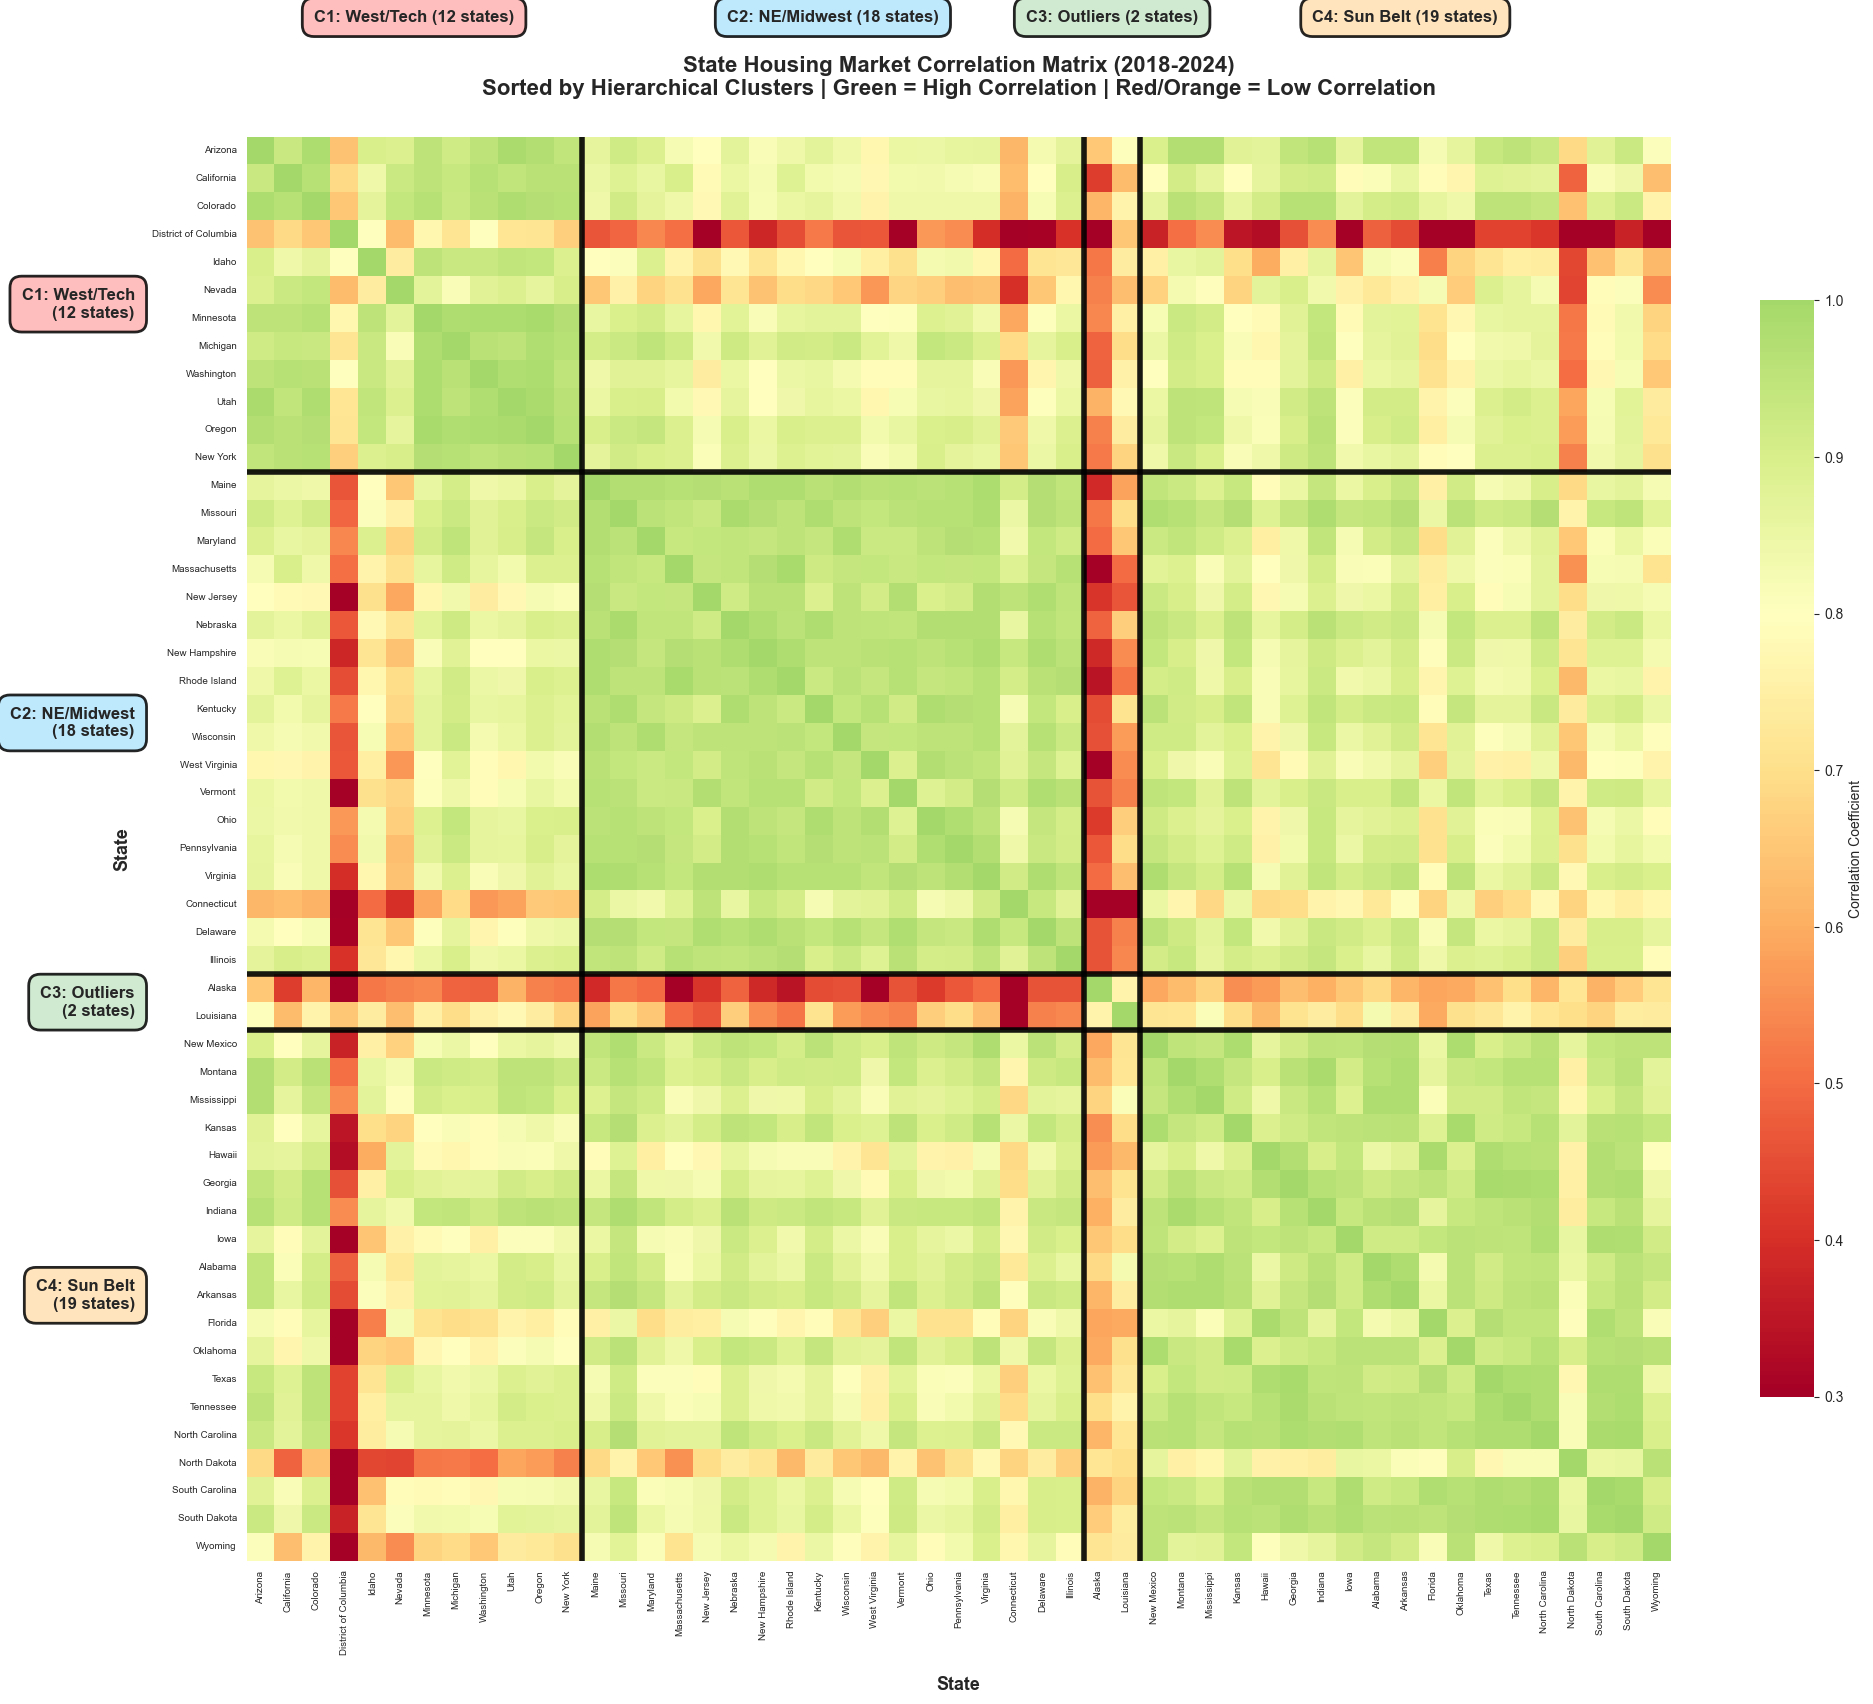

✓ Saved: viz1_correlation_heatmap_final.png


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sort states by cluster
cluster_df_sorted = cluster_df.sort_values('Cluster')
state_order = cluster_df_sorted['State'].tolist()

# Reorder correlation matrix
corr_sorted = correlation_matrix.loc[state_order, state_order]

# Create figure with extra space for labels
fig, ax = plt.subplots(figsize=(20, 18))

# Plot heatmap
sns.heatmap(corr_sorted, 
            cmap='RdYlGn', 
            center=0.8,
            vmin=0.3, 
            vmax=1.0,
            square=True,
            linewidths=0,
            cbar_kws={"shrink": 0.7, "label": "Correlation Coefficient"},
            xticklabels=state_order,
            yticklabels=state_order,
            ax=ax)

# Style the state labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=7, ha='center')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=7, va='center')

# Add cluster boundaries
cluster_sizes = cluster_df_sorted.groupby('Cluster').size().cumsum().values
for pos in cluster_sizes[:-1]:
    ax.axhline(y=pos, color='black', linewidth=4, alpha=0.9)
    ax.axvline(x=pos, color='black', linewidth=4, alpha=0.9)

# Add cluster labels OUTSIDE the plot area (no overlap!)
y_positions = np.append([0], cluster_sizes)
cluster_info = [
    ('C1: West/Tech\n(12 states)', '#FFB3B3'),
    ('C2: NE/Midwest\n(18 states)', '#B3E5FC'),
    ('C3: Outliers\n(2 states)', '#C8E6C9'),
    ('C4: Sun Belt\n(19 states)', '#FFE0B2')
]

# Calculate positions to avoid overlap
for i in range(len(cluster_sizes)):
    mid_point = (y_positions[i] + y_positions[i+1]) / 2
    
    # LEFT side labels (in the margin area)
    ax.text(-4, mid_point, cluster_info[i][0], 
            fontsize=12, fontweight='bold', 
            va='center', ha='right',
            bbox=dict(boxstyle='round,pad=0.7', 
                     facecolor=cluster_info[i][1], 
                     edgecolor='black', linewidth=2, alpha=0.85))
    
    # TOP labels (in the margin area)
    ax.text(mid_point, -4, cluster_info[i][0].replace('\n', ' '), 
            fontsize=12, fontweight='bold', 
            va='bottom', ha='center', rotation=0,
            bbox=dict(boxstyle='round,pad=0.7', 
                     facecolor=cluster_info[i][1], 
                     edgecolor='black', linewidth=2, alpha=0.85))

# Title and labels
plt.title('State Housing Market Correlation Matrix (2018-2024)\nSorted by Hierarchical Clusters | Green = High Correlation | Red/Orange = Low Correlation', 
          fontsize=16, fontweight='bold', pad=30)

# Move axis labels away from the heatmap
ax.set_xlabel('State', fontsize=13, fontweight='bold', labelpad=15)
ax.set_ylabel('State', fontsize=13, fontweight='bold', labelpad=15)

# Adjust layout to prevent cutting off labels
plt.subplots_adjust(left=0.08, right=0.97, top=0.95, bottom=0.08)

# Save
from pathlib import Path
output_dir = Path('../data/gold/zillow/q3')
output_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(output_dir / 'viz1_correlation_heatmap_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: viz1_correlation_heatmap_final.png")

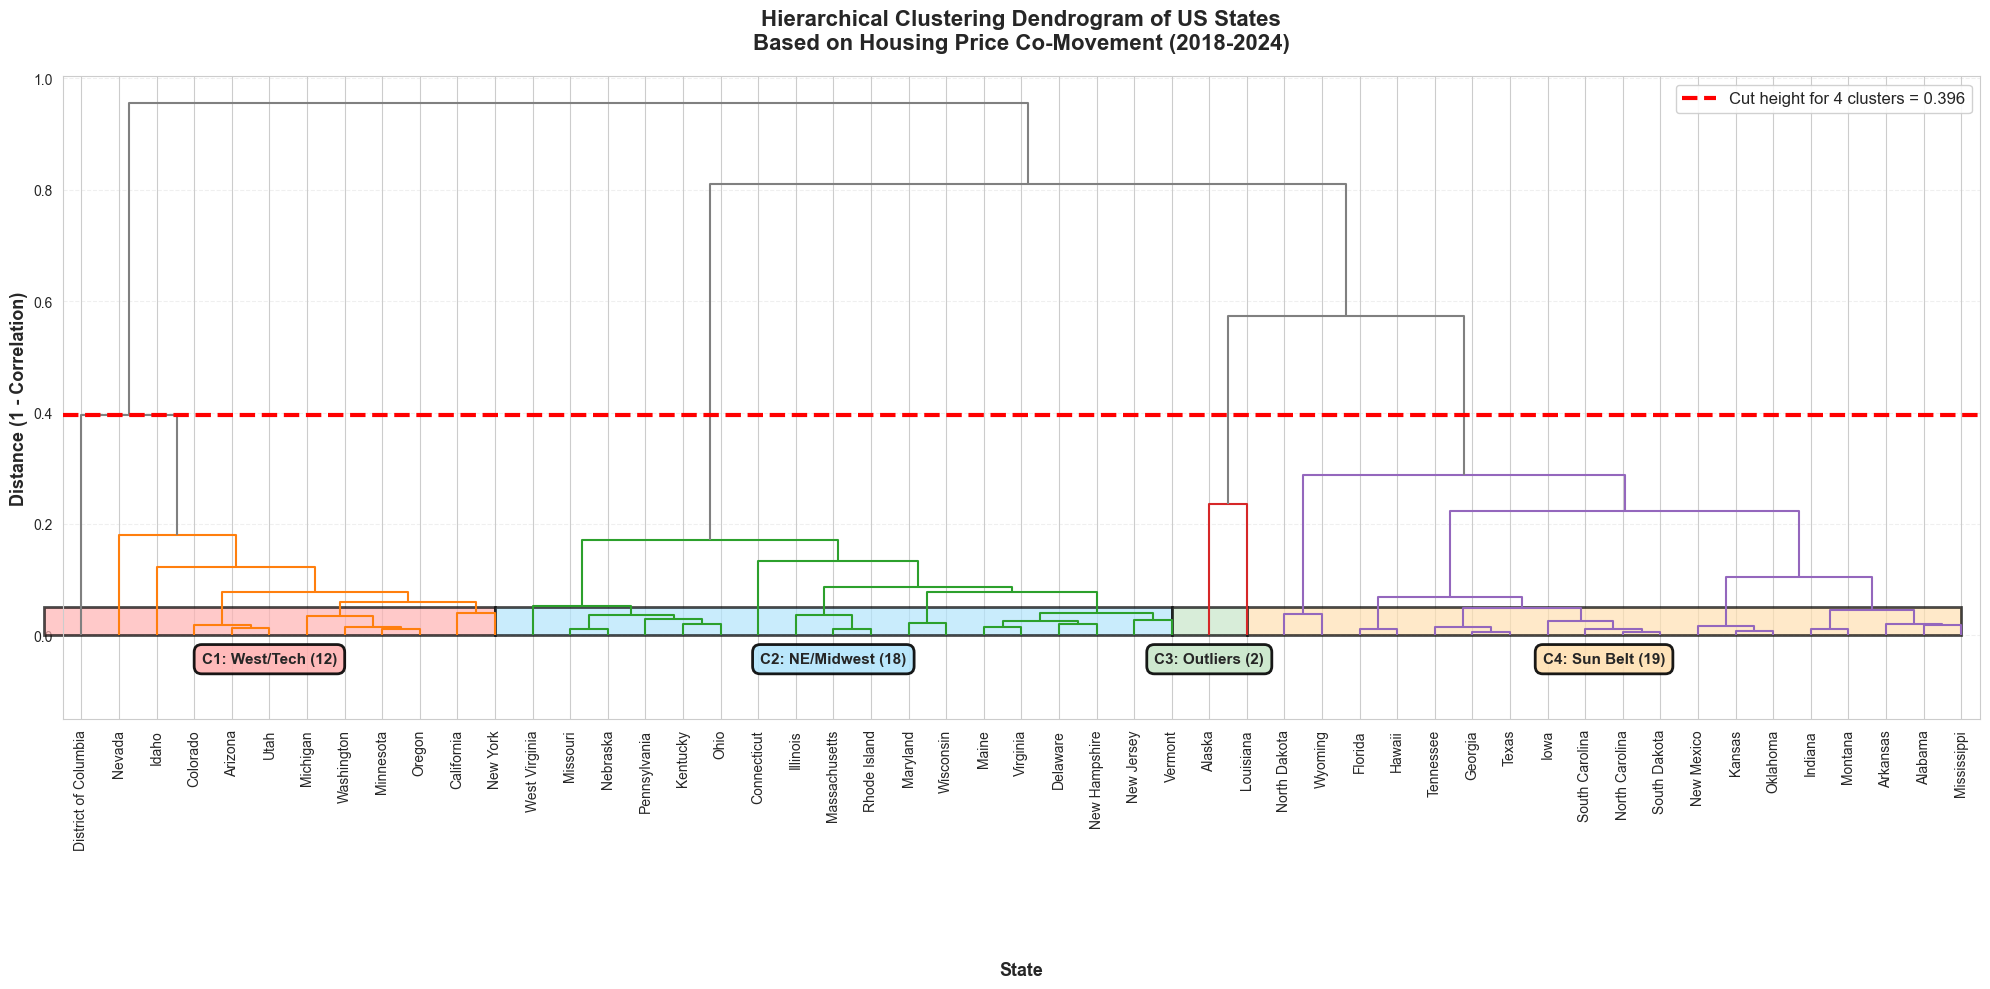

✓ Saved: viz2_dendrogram.png

Dendrogram shows:
  • Lower branches = more similar states
  • Height of merge = dissimilarity (1 - correlation)
  • Red line = where we cut to get 4 clusters
  • States are color-coded by their cluster


In [21]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import numpy as np

# Create figure
fig, ax = plt.subplots(figsize=(20, 10))

# Create dendrogram
dendro = dendrogram(
    linkage_matrix,
    labels=correlation_matrix.index.tolist(),
    ax=ax,
    leaf_font_size=10,
    leaf_rotation=90,
    color_threshold=linkage_matrix[-4, 2],  # Color by 4 clusters
    above_threshold_color='gray'
)

# Add horizontal line showing the cut for 4 clusters
cut_height = linkage_matrix[-4, 2]
ax.axhline(y=cut_height, color='red', linestyle='--', linewidth=3, 
           label=f'Cut height for 4 clusters = {cut_height:.3f}', zorder=10)

# Add cluster annotations
# Get the order of states from dendrogram
dendro_leaves = dendro['leaves']
state_labels = [correlation_matrix.index[i] for i in dendro_leaves]

# Find where each cluster appears in the dendrogram
cluster_ranges = {}
for cluster_id in range(optimal_k):
    cluster_states = cluster_df[cluster_df['Cluster'] == cluster_id]['State'].tolist()
    positions = [i for i, state in enumerate(state_labels) if state in cluster_states]
    if positions:
        cluster_ranges[cluster_id] = (min(positions), max(positions))

# Add colored boxes to show clusters at the bottom
cluster_colors = ['#FFB3B3', '#B3E5FC', '#C8E6C9', '#FFE0B2']
cluster_names = ['West/Tech (12)', 'NE/Midwest (18)', 'Outliers (2)', 'Sun Belt (19)']

for cluster_id, (start, end) in cluster_ranges.items():
    # Add colored rectangle at bottom
    ax.add_patch(plt.Rectangle(
        (start * 10 - 5, ax.get_ylim()[0]), 
        (end - start + 1) * 10, 
        ax.get_ylim()[1] * 0.05,
        facecolor=cluster_colors[cluster_id],
        edgecolor='black',
        linewidth=2,
        alpha=0.7,
        clip_on=False
    ))
    
    # Add text label
    mid_point = (start + end) / 2 * 10
    ax.text(mid_point, ax.get_ylim()[0] - ax.get_ylim()[1] * 0.03, 
            f'C{cluster_id + 1}: {cluster_names[cluster_id]}',
            ha='center', va='top', fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor=cluster_colors[cluster_id], 
                     edgecolor='black', linewidth=2, alpha=0.9))

# Styling
ax.set_title('Hierarchical Clustering Dendrogram of US States\nBased on Housing Price Co-Movement (2018-2024)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('State', fontsize=13, fontweight='bold', labelpad=80)
ax.set_ylabel('Distance (1 - Correlation)', fontsize=13, fontweight='bold')
ax.legend(loc='upper right', fontsize=12, framealpha=0.9)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Set y-axis limits to show full range
ax.set_ylim(bottom=ax.get_ylim()[0] - ax.get_ylim()[1] * 0.15)

plt.tight_layout()

# Save
from pathlib import Path
output_dir = Path('../data/gold/zillow/q3')
plt.savefig(output_dir / 'viz2_dendrogram.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: viz2_dendrogram.png")
print("\nDendrogram shows:")
print("  • Lower branches = more similar states")
print("  • Height of merge = dissimilarity (1 - correlation)")
print("  • Red line = where we cut to get 4 clusters")
print("  • States are color-coded by their cluster")

Creating Visualization 3: Between-Cluster Correlation Matrix...


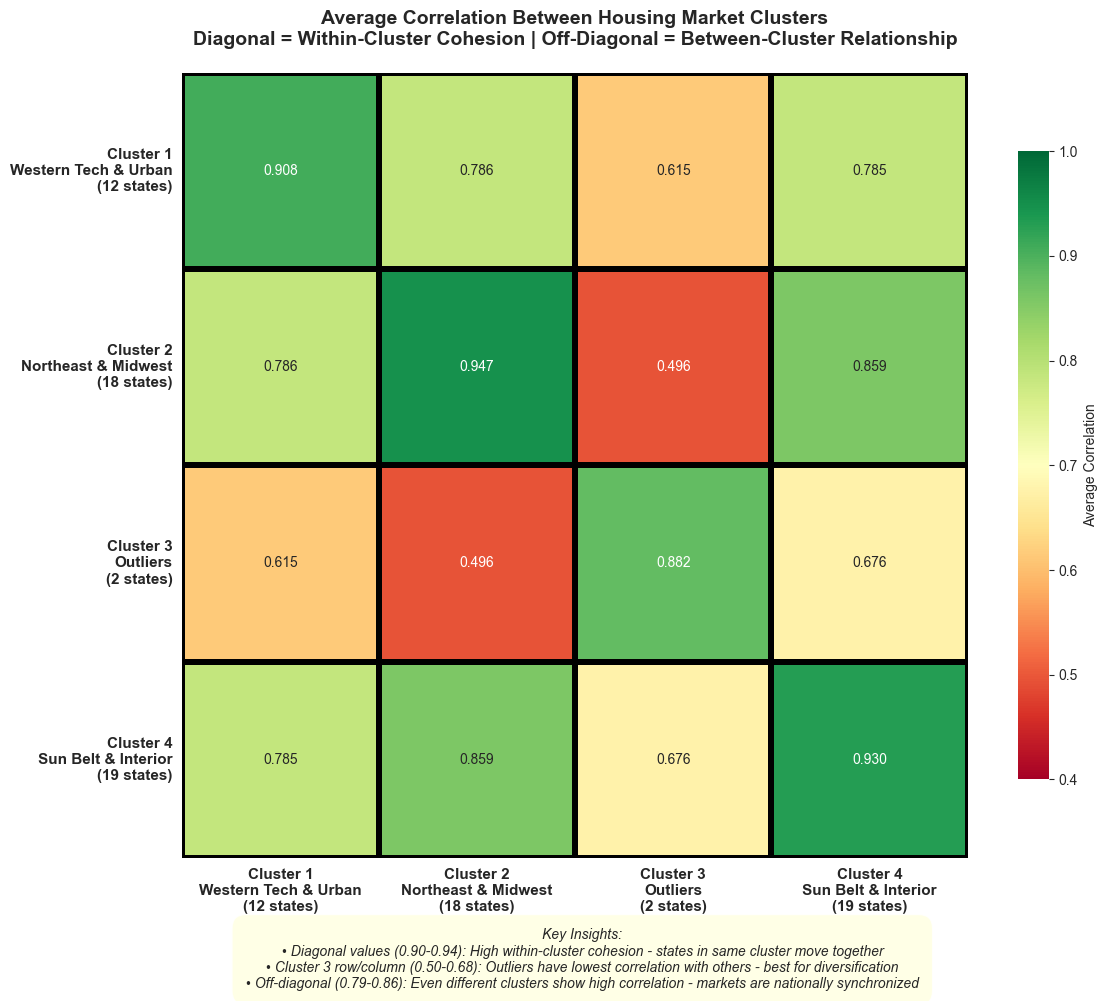

✓ Saved: viz3_between_cluster_correlation.png

Between-Cluster Correlation Matrix:
Cluster 1: 0.908  0.786  0.615  0.785  
Cluster 2: 0.786  0.947  0.496  0.859  
Cluster 3: 0.615  0.496  0.882  0.676  
Cluster 4: 0.785  0.859  0.676  0.930  


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("Creating Visualization 3: Between-Cluster Correlation Matrix...")

# Calculate between-cluster correlation matrix
between_corr_matrix = np.zeros((optimal_k, optimal_k))

for i in range(optimal_k):
    for j in range(optimal_k):
        states_i = cluster_df[cluster_df['Cluster'] == i]['State'].tolist()
        states_j = cluster_df[cluster_df['Cluster'] == j]['State'].tolist()
        
        # Average correlation between clusters
        between_corr_matrix[i, j] = correlation_matrix.loc[states_i, states_j].values.mean()

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot heatmap
sns.heatmap(between_corr_matrix, 
            annot=True,  # Show correlation values
            fmt='.3f',
            cmap='RdYlGn',
            center=0.7,
            vmin=0.4,
            vmax=1.0,
            square=True,
            cbar_kws={"label": "Average Correlation", "shrink": 0.8},
            linewidths=3,
            linecolor='black',
            ax=ax)

# Cluster labels
cluster_labels = [
    'Cluster 1\nWestern Tech & Urban\n(12 states)',
    'Cluster 2\nNortheast & Midwest\n(18 states)',
    'Cluster 3\nOutliers\n(2 states)',
    'Cluster 4\nSun Belt & Interior\n(19 states)'
]

ax.set_xticklabels(cluster_labels, fontsize=11, fontweight='bold', rotation=0, ha='center')
ax.set_yticklabels(cluster_labels, fontsize=11, fontweight='bold', rotation=0, va='center')

# Title
plt.title('Average Correlation Between Housing Market Clusters\n' +
          'Diagonal = Within-Cluster Cohesion | Off-Diagonal = Between-Cluster Relationship',
          fontsize=14, fontweight='bold', pad=20)

# Add interpretation text at bottom using figtext instead
interpretation = (
    "Key Insights:\n"
    "• Diagonal values (0.90-0.94): High within-cluster cohesion - states in same cluster move together\n"
    "• Cluster 3 row/column (0.50-0.68): Outliers have lowest correlation with others - best for diversification\n"
    "• Off-diagonal (0.79-0.86): Even different clusters show high correlation - markets are nationally synchronized"
)

fig.text(0.5, 0.02, interpretation, 
         ha='center', fontsize=10, style='italic', 
         bbox=dict(boxstyle='round,pad=1', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for text box

# Save
from pathlib import Path
output_dir = Path('../data/gold/zillow/q3')
plt.savefig(output_dir / 'viz3_between_cluster_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: viz3_between_cluster_correlation.png")

# Print the matrix for reference
print("\nBetween-Cluster Correlation Matrix:")
print("=" * 60)
for i in range(optimal_k):
    row_str = f"Cluster {i+1}: "
    for j in range(optimal_k):
        row_str += f"{between_corr_matrix[i, j]:.3f}  "
    print(row_str)
print("=" * 60)

Creating Visualization 4: Cluster Summary Dashboard (CLEAN)...


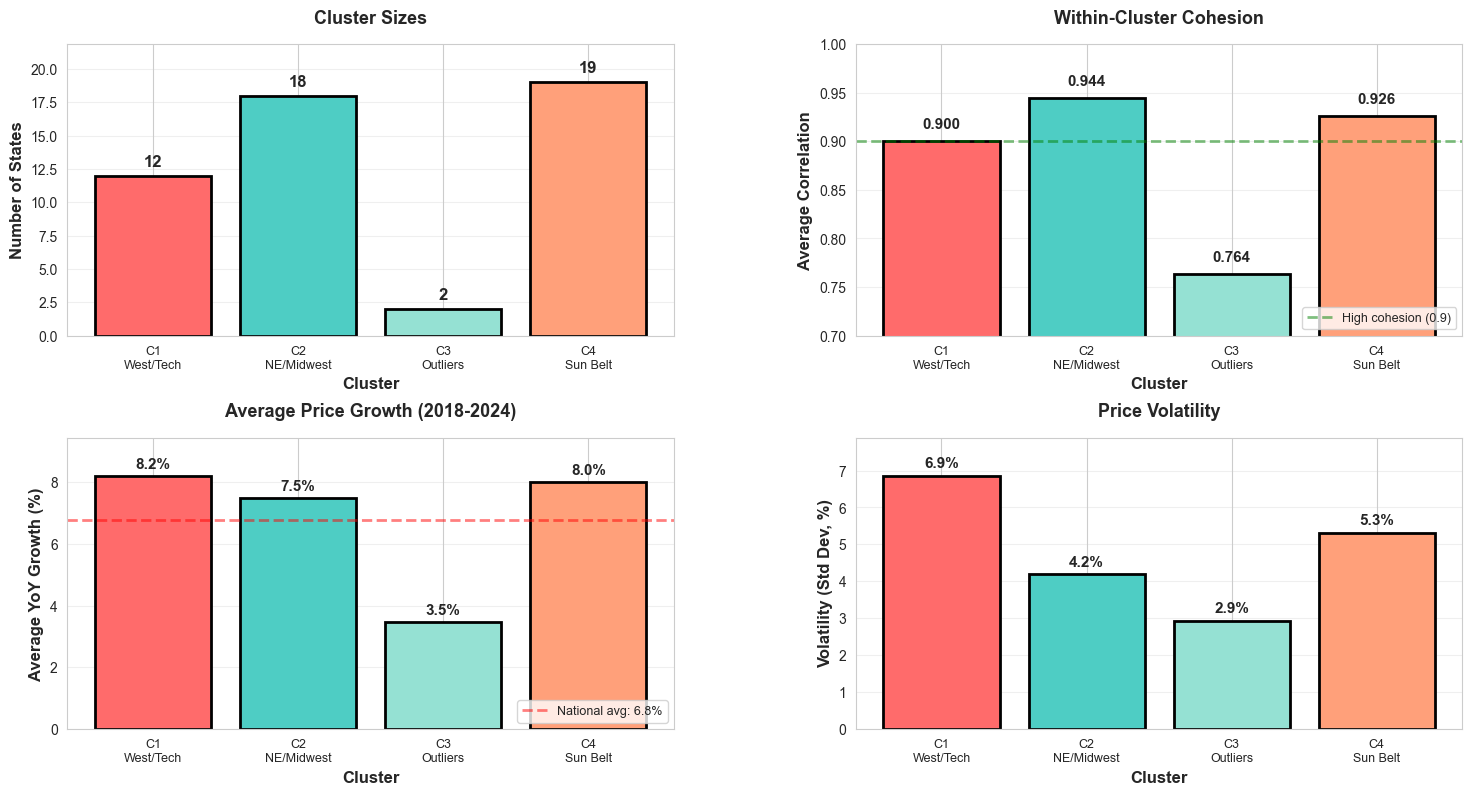

✓ Saved: viz5_risk_return_clean.png


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("Creating Visualization 4: Cluster Summary Dashboard (CLEAN)...")

# Gather cluster statistics
cluster_stats = []
for cluster_id in range(optimal_k):
    cluster_states = cluster_df[cluster_df['Cluster'] == cluster_id]['State'].tolist()
    
    # Within-cluster correlation
    cluster_corr_matrix = correlation_matrix.loc[cluster_states, cluster_states]
    if len(cluster_states) > 1:
        upper_tri = np.triu(cluster_corr_matrix.values, k=1)
        within_corr = upper_tri[upper_tri != 0].mean()
    else:
        within_corr = 1.0
    
    # Average price growth
    avg_growth = (price_matrix_clean[cluster_states].mean().mean() * 100)
    
    # Volatility (std of growth rates)
    volatility = (price_matrix_clean[cluster_states].std().mean() * 100)
    
    cluster_stats.append({
        'cluster': cluster_id,
        'n_states': len(cluster_states),
        'within_corr': within_corr,
        'avg_growth': avg_growth,
        'volatility': volatility
    })

# Create dashboard with 4 subplots
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

cluster_names = ['West/Tech', 'NE/Midwest', 'Outliers', 'Sun Belt']
cluster_colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#FFA07A']

# ============================================================================
# Plot 1: Cluster Sizes (Top Left)
# ============================================================================
ax1 = fig.add_subplot(gs[0, 0])
sizes = [s['n_states'] for s in cluster_stats]
bars1 = ax1.bar(range(1, optimal_k + 1), sizes, color=cluster_colors, edgecolor='black', linewidth=2)
ax1.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of States', fontsize=12, fontweight='bold')
ax1.set_title('Cluster Sizes', fontsize=13, fontweight='bold', pad=15)
ax1.set_xticks(range(1, optimal_k + 1))
ax1.set_xticklabels([f'C{i+1}\n{cluster_names[i]}' for i in range(optimal_k)], fontsize=9)
ax1.set_ylim([0, max(sizes) * 1.15])
ax1.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=12)

# ============================================================================
# Plot 2: Within-Cluster Correlation (Top Right)
# ============================================================================
ax2 = fig.add_subplot(gs[0, 1])
corrs = [s['within_corr'] for s in cluster_stats]
bars2 = ax2.bar(range(1, optimal_k + 1), corrs, color=cluster_colors, edgecolor='black', linewidth=2)
ax2.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Correlation', fontsize=12, fontweight='bold')
ax2.set_title('Within-Cluster Cohesion', fontsize=13, fontweight='bold', pad=15)
ax2.set_xticks(range(1, optimal_k + 1))
ax2.set_xticklabels([f'C{i+1}\n{cluster_names[i]}' for i in range(optimal_k)], fontsize=9)
ax2.set_ylim([0.7, 1.0])
ax2.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, linewidth=2, label='High cohesion (0.9)')
ax2.grid(axis='y', alpha=0.3)
ax2.legend(fontsize=9, loc='lower right')

for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# ============================================================================
# Plot 3: Average Price Growth (Middle Left)
# ============================================================================
ax3 = fig.add_subplot(gs[1, 0])
growths = [s['avg_growth'] for s in cluster_stats]
bars3 = ax3.bar(range(1, optimal_k + 1), growths, color=cluster_colors, edgecolor='black', linewidth=2)
ax3.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax3.set_ylabel('Average YoY Growth (%)', fontsize=12, fontweight='bold')
ax3.set_title('Average Price Growth (2018-2024)', fontsize=13, fontweight='bold', pad=15)
ax3.set_xticks(range(1, optimal_k + 1))
ax3.set_xticklabels([f'C{i+1}\n{cluster_names[i]}' for i in range(optimal_k)], fontsize=9)
ax3.set_ylim([0, max(growths) * 1.15])
ax3.axhline(y=np.mean(growths), color='red', linestyle='--', alpha=0.5, linewidth=2, 
            label=f'National avg: {np.mean(growths):.1f}%')
ax3.grid(axis='y', alpha=0.3)
ax3.legend(fontsize=9, loc='lower right')

for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.15,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# ============================================================================
# Plot 4: Volatility (Middle Right)
# ============================================================================
ax4 = fig.add_subplot(gs[1, 1])
vols = [s['volatility'] for s in cluster_stats]
bars4 = ax4.bar(range(1, optimal_k + 1), vols, color=cluster_colors, edgecolor='black', linewidth=2)
ax4.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax4.set_ylabel('Volatility (Std Dev, %)', fontsize=12, fontweight='bold')
ax4.set_title('Price Volatility', fontsize=13, fontweight='bold', pad=15)
ax4.set_xticks(range(1, optimal_k + 1))
ax4.set_xticklabels([f'C{i+1}\n{cluster_names[i]}' for i in range(optimal_k)], fontsize=9)
ax4.set_ylim([0, max(vols) * 1.15])
ax4.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.15,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)


from pathlib import Path
output_dir = Path('../data/gold/zillow/q3')
plt.savefig(output_dir / 'viz4_risk_return_clean.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: viz5_risk_return_clean.png")

Creating SIMPLE Risk-Return Chart...


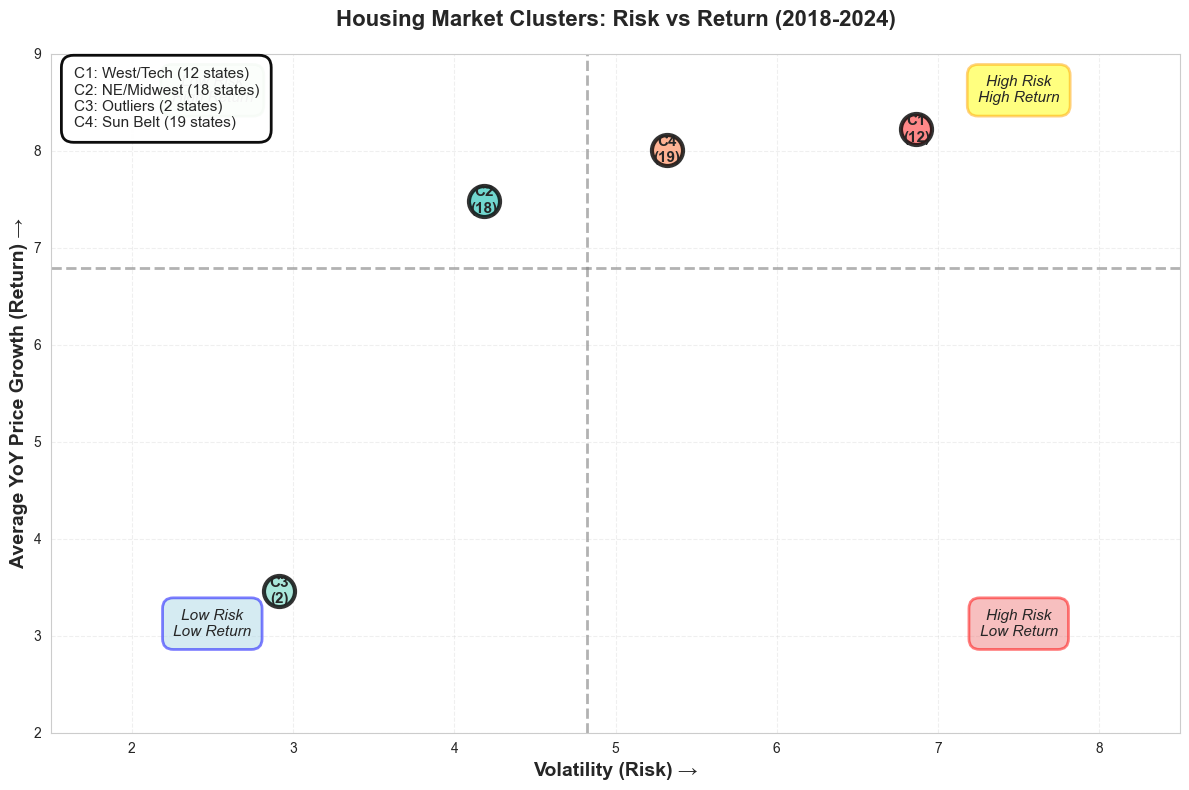

✓ Saved: viz5_risk_return_clean.png

CLUSTER POSITIONING:

C1: West/Tech: HIGH RISK, HIGH RETURN
  Growth: 8.2% | Volatility: 6.9%

C2: NE/Midwest: ✓ LOW RISK, HIGH RETURN (Best!)
  Growth: 7.5% | Volatility: 4.2%

C3: Outliers: LOW RISK, LOW RETURN
  Growth: 3.5% | Volatility: 2.9%

C4: Sun Belt: HIGH RISK, HIGH RETURN
  Growth: 8.0% | Volatility: 5.3%


In [29]:
import matplotlib.pyplot as plt
import numpy as np

print("Creating SIMPLE Risk-Return Chart...")

# Get cluster statistics
cluster_data = []
for cluster_id in range(optimal_k):
    cluster_states = cluster_df[cluster_df['Cluster'] == cluster_id]['State'].tolist()
    avg_growth = (price_matrix_clean[cluster_states].mean().mean() * 100)
    volatility = (price_matrix_clean[cluster_states].std().mean() * 100)
    
    cluster_data.append({
        'id': cluster_id,
        'n_states': len(cluster_states),
        'growth': avg_growth,
        'volatility': volatility
    })

# Create clean plot
fig, ax = plt.subplots(figsize=(12, 8))

cluster_names = ['C1: West/Tech', 'C2: NE/Midwest', 'C3: Outliers', 'C4: Sun Belt']
cluster_colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#FFA07A']

# Plot ONE point per cluster
for i, data in enumerate(cluster_data):
    ax.scatter(data['volatility'], data['growth'], 
               s=500,  # Fixed size for all
               color=cluster_colors[i], 
               edgecolor='black', 
               linewidth=3,
               alpha=0.8,
               zorder=3)
    
    # Add label inside the circle
    ax.text(data['volatility'], data['growth'],
            f"C{i+1}\n({data['n_states']})", 
            fontsize=11, fontweight='bold',
            ha='center', va='center', zorder=4)

# Add quadrant lines
mean_vol = np.mean([d['volatility'] for d in cluster_data])
mean_growth = np.mean([d['growth'] for d in cluster_data])

ax.axhline(y=mean_growth, color='gray', linestyle='--', linewidth=2, alpha=0.6)
ax.axvline(x=mean_vol, color='gray', linestyle='--', linewidth=2, alpha=0.6)

# Add quadrant labels
ax.text(2.5, 8.5, 'Low Risk\nHigh Return', 
        fontsize=11, style='italic', ha='center',
        bbox=dict(boxstyle='round,pad=0.7', facecolor='lightgreen', alpha=0.5, edgecolor='green', linewidth=2))

ax.text(7.5, 8.5, 'High Risk\nHigh Return', 
        fontsize=11, style='italic', ha='center',
        bbox=dict(boxstyle='round,pad=0.7', facecolor='yellow', alpha=0.5, edgecolor='orange', linewidth=2))

ax.text(2.5, 3, 'Low Risk\nLow Return', 
        fontsize=11, style='italic', ha='center',
        bbox=dict(boxstyle='round,pad=0.7', facecolor='lightblue', alpha=0.5, edgecolor='blue', linewidth=2))

ax.text(7.5, 3, 'High Risk\nLow Return', 
        fontsize=11, style='italic', ha='center',
        bbox=dict(boxstyle='round,pad=0.7', facecolor='lightcoral', alpha=0.5, edgecolor='red', linewidth=2))

# Styling
ax.set_xlabel('Volatility (Risk) →', fontsize=14, fontweight='bold')
ax.set_ylabel('Average YoY Price Growth (Return) →', fontsize=14, fontweight='bold')
ax.set_title('Housing Market Clusters: Risk vs Return (2018-2024)',
             fontsize=16, fontweight='bold', pad=20)

# Legend
legend_text = '\n'.join([f"{cluster_names[i]} ({cluster_data[i]['n_states']} states)" 
                         for i in range(optimal_k)])
ax.text(0.02, 0.98, legend_text, transform=ax.transAxes,
        fontsize=11, va='top', ha='left',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='white', 
                 edgecolor='black', linewidth=2, alpha=0.95))

ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim([1.5, 8.5])
ax.set_ylim([2, 9])

plt.tight_layout()

# Save
from pathlib import Path
output_dir = Path('../data/gold/zillow/q3')
plt.savefig(output_dir / 'viz5_risk_return_clean.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: viz5_risk_return_clean.png")

# Print summary
print("\n" + "="*60)
print("CLUSTER POSITIONING:")
for i, data in enumerate(cluster_data):
    position = ""
    if data['volatility'] < mean_vol and data['growth'] > mean_growth:
        position = "✓ LOW RISK, HIGH RETURN (Best!)"
    elif data['volatility'] > mean_vol and data['growth'] > mean_growth:
        position = "HIGH RISK, HIGH RETURN"
    elif data['volatility'] < mean_vol and data['growth'] < mean_growth:
        position = "LOW RISK, LOW RETURN"
    else:
        position = "⚠ HIGH RISK, LOW RETURN (Avoid)"
    
    print(f"\n{cluster_names[i]}: {position}")
    print(f"  Growth: {data['growth']:.1f}% | Volatility: {data['volatility']:.1f}%")
print("="*60)